# CMIP6 Antartica

**Following steps are included in this script:**

1. Load netCDF files
2. Remove Antartica by removing data south of 60°
3. Save and replace netcdf files

In [5]:
# ========== Packages ==========
import xarray as xr
import pandas as pd
import numpy as np
import dask
import os
import glob

### Functions

In [2]:
def save_file(save_file, folder, save_var=True):
    """
    Save files as netCDF.

    Args:
        savefile (dict or dataset): Dictionary of xarray datasets or dataset.
        folder (string): Name of folder data is saved in.
        save_var (boolean): If True, data is saved separately for each variable. If false, one file is saved with all variables.
        

    Returns:
        nc_out: Path were data is saved in.
    """
    
    if save_var:
        for key, ds in ds_dict.items():
            for var in ds:
                # Variable to keep
                variable_to_keep = var
                dimensions_to_keep = {'time', 'lat', 'lon'}
                coordinates_to_keep = {'time', 'lat', 'lon'}

                if any('depth' in ds[var].dims for var in ds.variables):
                    dimensions_to_keep.add('depth')
                    coordinates_to_keep.add('depth')

                # Create a new dataset with only the desired variable
                ds_var = ds[[variable_to_keep]]

                # Keep only the desired dimensions
                ds_var = ds_var.isel({dim: slice(None) for dim in dimensions_to_keep.intersection(ds_var.dims)})

                # Set the desired coordinates
                coords_to_set = set(ds_var.variables).intersection(coordinates_to_keep)
                ds_var = ds_var.set_coords(list(coords_to_set))

                savepath = f'../../data/CMIP6/{ds_var.experiment_id}/{folder}/{var}/'
                filename = f'CMIP.{ds_var.source_id}.{ds_var.experiment_id}.{var}_regridded.nc'
                nc_out = os.path.join(savepath, filename)
                os.makedirs(savepath, exist_ok=True) 
                if os.path.exists(nc_out):
                       # inp = input(f"Delete old file {filename} (y/n):")
                       # if inp.lower() in ["y"]:
                            os.remove(nc_out)
                            print(f"File  with path: {nc_out} removed")
                      #  else:
                      #      filename = "temp_file.nc"
                      #      nc_out = os.path.join(savepath, filename)
                      #      print(f"Filename change to {filename}")

                # Save to netcdf file
                with dask.config.set(scheduler='threads'):
                    ds_var.to_netcdf(nc_out)
                    print(f"File with path: {nc_out} saved")
       
    else:
        for key in save_file.keys():
            ds_in = save_file[key]
            filename = f'CMIP.{ds_in.source_id}.{ds_in.experiment_id}_regridded.nc'
            savepath = f'../data/CMIP6/{ds_in.experiment_id}/{folder}'
            nc_out = os.path.join(savepath, filename)
            os.makedirs(savepath, exist_ok=True) 
            if os.path.exists(nc_out):
                inp = input(f"Delete old file {filename} (y/n):")
                if inp.lower() in ["y"]:
                    os.remove(nc_out)
                    print(f"File  with path: {nc_out} removed")
                else:
                    filename = "temp_file.nc"
                    nc_out = os.path.join(savepath, filename)
                    print(f"Filename change to {filename}")

            # Save to netcdf file
            with dask.config.set(scheduler='threads'):
                ds_in.to_netcdf(nc_out)

    return nc_out

In [3]:
# ========= Create a helper function to open the dataset ========
def open_dataset(filename):
    ds = xr.open_dataset(filename)
    return ds

# Define a helper function to open and merge datasets
def open_and_merge_datasets(folder, model, experiment_id, variables):
    filepaths = []
    for var in variables:
        path = f'../../data/CMIP6/{experiment_id}/{folder}/{var}'
        fp = glob.glob(os.path.join(path, f'CMIP.{model}.{experiment_id}.{var}_regridded.nc'))
        if fp:
            filepaths.append(fp[0])
        else:
            print(f"No file found for variable '{var}' in model '{model}'.")
            print(fp)

    datasets = [xr.open_dataset(fp) for fp in filepaths]
    ds = xr.merge(datasets)
    return ds

### 1. Load netCDF files

In [9]:
# ========= Define period, models and path ==============
variable=['mrro', 'lai', 'pr', 'tran']
experiment_id = 'ssp126'
#source_id = ['TaiESM1', 'BCC-CSM2-MR',  'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'CESM2-WACCM', 'NorESM2-MM'] #
source_id = ['BCC-CSM2-MR',  'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'NorESM2-MM'] #
folder='preprocessed'

# ========= Use Dask to parallelize computations ==========
dask.config.set(scheduler='processes')

# Create dictionary using a dictionary comprehension and Dask
ds_dict = dask.compute({model: open_and_merge_datasets(folder, model, experiment_id, variable) for model in source_id})[0]

In [5]:
# ========= Have a look into the dictionary =======
print(list(ds_dict.keys()))
ds_dict[list(ds_dict.keys())[0]][variable]

['TaiESM1', 'BCC-CSM2-MR', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'CESM2-WACCM', 'NorESM2-MM']


<xarray.DataArray 'mrso_1m' (time: 1980, lat: 180, lon: 360)>
[128304000 values with dtype=float64]
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * lon      (lon) int64 -180 -179 -178 -177 -176 -175 ... 175 176 177 178 179
Attributes:
    standard_name:  mass_content_of_liquid_and_frozen__water_in_1m_soil_column
    long_name:      Total Soil Moisture Content of 1 m Column
    comment:        The mass per unit area  (summed over all soil layers unti...
    units:          kg/m²

In [7]:
def find_last_datapoint(ds_dict, variable):
    
    data = ds_dict[list(ds_dict.keys())[5]][variable]

    # Reverse the time dimension (start from the end)
    data = data.isel(time=slice(None, None, -1))

    # Find the first time index with non-NaN values
    non_nan_time_index = data.notnull().any(dim=["lat", "lon"]).argmax().values

    # Find the first time index with non-zero values
    non_zero_time_index = (data != 0).any(dim=["lat", "lon"]).argmax().values

    # Find the maximum of both time indices to get the first time index with actual values
    last_actual_values_time_index = max(non_nan_time_index, non_zero_time_index)

    # Convert it to index from start of the data
    last_actual_values_time_index = len(data.time) - 1 - last_actual_values_time_index

    last_actual_values_time = data.time.isel(time=last_actual_values_time_index).values

    print("Last time index with actual values:", last_actual_values_time_index)
    print("Last time with actual values:", last_actual_values_time)

In [8]:
find_last_datapoint(ds_dict, variable)

Last time index with actual values: 1979
Last time with actual values: 1850-01-16 12:00:00


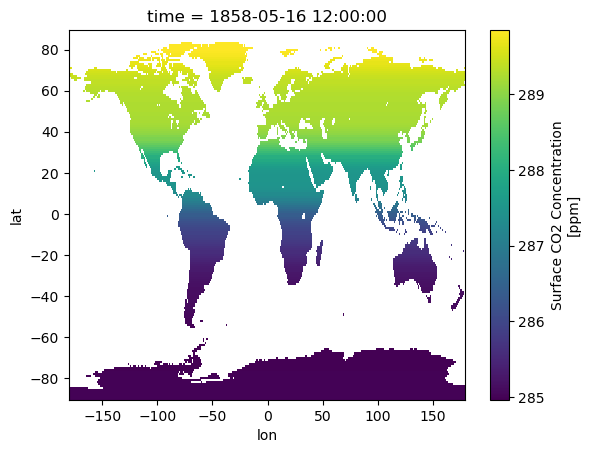

In [8]:
ds_dict[list(ds_dict.keys())[8]][variable].isel(time=100).plot()

### 2. Remove Antartica

In [10]:
# Slice the dataset to exclude Antarctica latitudes
for i, (name, ds) in enumerate(ds_dict.items()):
    ds_no_antarctica = ds.sel(lat=(ds.lat > -60))
    # Add comment about changes to data
    if 'log' in ds_no_antarctica.attrs:
        log_old = ds_no_antarctica.attrs['log']
        ds_no_antarctica.attrs['log'] = f'Dataset sliced along lat 60 to remove Antartica. // {log_old}'
    else:
        ds_no_antarctica.attrs['log'] = 'Dataset sliced along lat 60 to remove Antartica.'
    ds_dict[name] = ds_no_antarctica

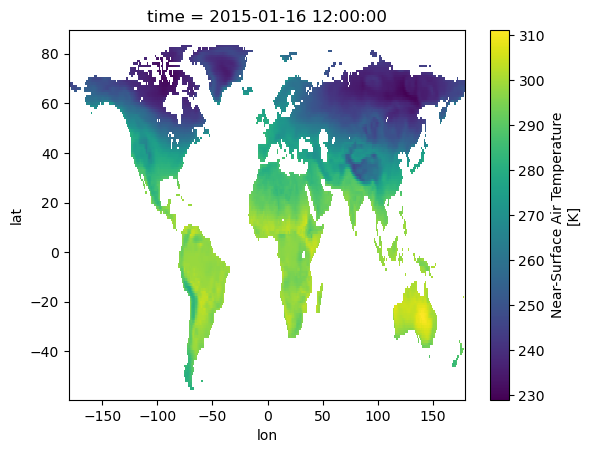

In [15]:
ds_dict[list(ds_dict.keys())[0]][variable].isel(time=0).plot()

### 4. Save and replace netcdf files

In [11]:
# =========== Store file and remove any former one ==========
nc_out = save_file(ds_dict, folder=folder)

File  with path: ../../data/CMIP6/ssp126/preprocessed/mrro/CMIP.BCC-CSM2-MR.ssp126.mrro_regridded.nc removed
File with path: ../../data/CMIP6/ssp126/preprocessed/mrro/CMIP.BCC-CSM2-MR.ssp126.mrro_regridded.nc saved
File  with path: ../../data/CMIP6/ssp126/preprocessed/lai/CMIP.BCC-CSM2-MR.ssp126.lai_regridded.nc removed
File with path: ../../data/CMIP6/ssp126/preprocessed/lai/CMIP.BCC-CSM2-MR.ssp126.lai_regridded.nc saved
File  with path: ../../data/CMIP6/ssp126/preprocessed/pr/CMIP.BCC-CSM2-MR.ssp126.pr_regridded.nc removed
File with path: ../../data/CMIP6/ssp126/preprocessed/pr/CMIP.BCC-CSM2-MR.ssp126.pr_regridded.nc saved
File  with path: ../../data/CMIP6/ssp126/preprocessed/tran/CMIP.BCC-CSM2-MR.ssp126.tran_regridded.nc removed
File with path: ../../data/CMIP6/ssp126/preprocessed/tran/CMIP.BCC-CSM2-MR.ssp126.tran_regridded.nc saved
File  with path: ../../data/CMIP6/ssp126/preprocessed/mrro/CMIP.CanESM5.ssp126.mrro_regridded.nc removed
File with path: ../../data/CMIP6/ssp126/preproc

In [ ]:
# =========== Check stored file ==============
xr.open_dataset(nc_out)